# COLD Example

This script shows how to run COLD from a csv file that store time series information

In [1]:
import numpy as np
import os
import pathlib
import pandas as pd

# Imports from this package
from pyxccd import cold_detect, cold_detect_flex
from pyxccd.utils import read_data

In [3]:
Landsat_bandname = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'Thermal']
t_c = -200  # the threshold used for get_breakcategory
w = np.pi * 2 / 365.25
slope_scale = 10000  # slope_in_rec_cg = original_slope * slope_scale, we used this way to keep precision for
                     # model coefficients in float datatype

def get_breakcategory(ccd_plot, i_curve):
    """
    get break category:
    :param ccd_plot: rec_cg
    :param i_curve: the number of the curve to be analysised
    :return: 1 - disturbance break; 2 - natural recovery; 3 - aforestation
    see section 3.3.7 in Zhu, Z., Zhang, J., Yang, Z., Aljaddani, A. H., Cohen, W. B., Qiu, S., & Zhou, C. (2020).
    Continuous monitoring of land disturbance based on Landsat time series. Remote Sensing of Environment, 238, 111116.
    """
    if ccd_plot[i_curve]['magnitude'][3] > t_c and ccd_plot[i_curve]['magnitude'][2] < -t_c and \
            ccd_plot[i_curve]['magnitude'][4] < -t_c:
        if ccd_plot[i_curve + 1]['coefs'][3, 1] > np.abs(ccd_plot[i_curve]['coefs'][3, 1]) and \
                ccd_plot[i_curve + 1]['coefs'][2, 1] < -np.abs(ccd_plot[i_curve]['coefs'][2, 1]) and \
                ccd_plot[i_curve + 1]['coefs'][4, 1] < -np.abs(ccd_plot[i_curve]['coefs'][4, 1]):
            return 3
        else:
            return 2
    else:
        return 1
    
TEST_RESOURCE_DPATH = (pathlib.Path.cwd() / '../../tests/resources').resolve()
assert TEST_RESOURCE_DPATH.exists()

In [6]:
# running COLD for a Landsat time series provided by a csv
in_path = TEST_RESOURCE_DPATH / 'spectral_336_3980_obs.csv'
data = read_data(in_path)
dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas, sensor = data.copy()  # exclude header
cold_result = cold_detect(dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas)


In [7]:
import seaborn as sns  # for plotting
import matplotlib.pyplot as plt  # for plotting
from matplotlib.lines import Line2D

sns.set(style="darkgrid")
sns.set_context("notebook")

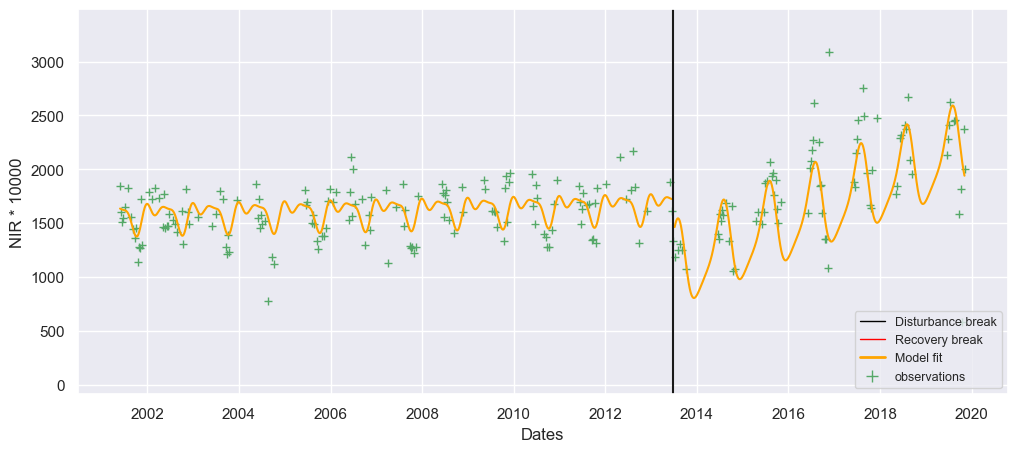

In [8]:
# plot original time series, curve fitting and breakpoint from COLD result
data = pd.DataFrame(data.T, columns = ['dates'] + Landsat_bandname + ['qa', 'sensor'])
band = 4  # the band to plot, 4 is nir band, change it as you need

f, ax = plt.subplots(1, figsize=(12, 5))

# plot clean observatyion
data_clean = data[data['qa'] == 0].copy()

calendar_dates = [pd.Timestamp.fromordinal(row) for row in data_clean["dates"]]
data_clean.loc[:, 'dates'] = calendar_dates  # convert ordinal dates to calendar

# plot observations
ax.plot('dates', Landsat_bandname[band - 1], 'g+', data=data_clean, label='Observations')

# plot COLD predicted curve
plot_cold = pd.DataFrame(columns=['Trend', 'Annual', 'Semiannual', 'trimodal', 'predicted'])  # initialize a
                                                        # dataframe for saving predicted values for each component
for i in range(len(cold_result)):
    j = np.arange(cold_result[i]['t_start'], cold_result[i]['t_end'] + 1, 1)
    plot_cold_sub = pd.DataFrame({'dates': j,
                                  'trend': j * cold_result[i]['coefs'][band - 1][1] / slope_scale +
                                           cold_result[i]['coefs'][band - 1][0],
                                  'annual': np.cos(w * j) * cold_result[i]['coefs'][band - 1][2] +
                                            np.sin(w * j) * cold_result[i]['coefs'][band - 1][3],
                                  'semiannual': np.cos(2 * w * j) * cold_result[i]['coefs'][band - 1][4] +
                                                np.sin(2 * w * j) * cold_result[i]['coefs'][band - 1][5],
                                  'trimodal': np.cos(3 * w * j) * cold_result[i]['coefs'][band - 1][6] +
                                              np.sin(3 * w * j) * cold_result[i]['coefs'][band - 1][7]})

    plot_cold_sub['predicted'] = plot_cold_sub['trend'] + plot_cold_sub['annual'] + plot_cold_sub['semiannual'] + \
                                 plot_cold_sub['trimodal']

    calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in plot_cold_sub["dates"]]
    plot_cold_sub.loc[:, 'dates'] = calendar_dates
    g = sns.lineplot(x="dates", y="predicted", data=plot_cold_sub, label="Model fit", ax=ax, color="orange")
    g.legend_.remove()  # remove legend temporally
    plot_cold = pd.concat([plot_cold, plot_cold_sub], sort=True)

ax.set_ylabel("{} * 10000".format(Landsat_bandname[band - 1]), fontsize=12)
ax.set_xlabel("Dates", fontsize=12)

# plot different categories of breaks, natural recovery used red color,
# disturbance/afforestation use black (real disturbances)
for i in range(len(cold_result) - 1):
    if get_breakcategory(cold_result, i) == 2:  # recovery break
        ax.axvline(pd.Timestamp.fromordinal(cold_result[i]['t_break']), color='r')
    else:
        ax.axvline(pd.Timestamp.fromordinal(cold_result[i]['t_break']), color='k')

# regenerating legend
legend_elements = [Line2D([0], [0], color='black', lw=1, label='Disturbance break'),
                   Line2D([0], [0], color='red', lw=1, label='Recovery break'),
                   Line2D([0], [0], color='orange', lw=2, label='Model fit'),
                   Line2D([], [], color='g', marker='+', linestyle='None',
                          markersize=8, label='observations')]
ax.legend(handles=legend_elements, loc='lower right', prop={'size': 9})

# set x_tick size for aesthetic reason
# for tick in ax.xaxis.get_major_ticks():
#     tick.label.set_fontsize(13)

# the last thing is to set bounds of y axis, as the 'clean' observations may also include outliers.
extra = (np.max(plot_cold['predicted']) - np.min(plot_cold['predicted']))/2
t = ax.set(ylim=(np.min(plot_cold['predicted']) - extra, np.max(plot_cold['predicted']) + extra))

In [10]:
# the below is an example for using cold_detect_flex to allow any band combination
# note that the input bands must be scaled to [0, 10000]
in_path = TEST_RESOURCE_DPATH / 'spectral_336_3980_obs.csv'
data = read_data(in_path)
dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas, sensor = data.copy()  
cold_results = cold_detect_flex(dates, np.stack((swir1s, swir2s), axis=1), qas, tmask_b1_index=1, tmask_b2_index=2) # note that you have to specify two band inputs for tmask procedure, the default COLD uses the green and swir1 bands
print(cold_results)



[(730632, 734832, 735016, 1, 142, 8, 100, [[-4.5089683e+03,  7.0948975e+01, -2.9183716e+02,  0.0000000e+00,  2.1599464e+01, -4.7565880e+00,  0.0000000e+00,  0.0000000e+00], [-3.2397896e+03,  4.9559429e+01, -1.7993681e+02,  1.7089237e+00,  1.6707226e+00, -1.7547698e+00,  0.0000000e+00,  0.0000000e+00], [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00], [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00], [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00], [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00], [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00], [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00